Jetzt der 1. Versuch für unsere eigenen Piano-Daten

# 0. Imports

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import math
import numpy as np

import random

gpu nutzen

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Daten Vorbereiten

## Ideen für Special Tokens

Padding, Start of Stream (SOS), und End of Stream (EOS) Tokens sind wichtige Konzepte beim Arbeiten mit Sequenzdaten, insbesondere in Modellen wie Transformern. Sie helfen dabei, Sequenzen auf eine einheitliche Länge zu bringen und dem Modell zu signalisieren, wann eine Eingabe- oder Ausgabesequenz beginnt und endet.

### Padding Token

- **Padding Token** wird verwendet, um alle Sequenzen auf eine einheitliche Länge zu bringen.
- Da Ihre Daten aus binären Vektoren bestehen, könnte ein Padding Token einfach ein Vektor aus Nullen sein (d.h. kein Tastendruck).

### Start of Stream (SOS) Token

- **Start of Stream Token** signalisiert den Beginn einer Sequenz.
- Ein möglicher SOS-Token könnte ein Vektor sein, bei dem nur das erste Element auf 1 gesetzt ist und der Rest auf 0 (d.h. `[1, 0, 0, ..., 0]`).

### End of Stream (EOS) Token

- **End of Stream Token** signalisiert das Ende einer Sequenz.
- Ein möglicher EOS-Token könnte ein Vektor sein, bei dem nur das letzte Element auf 1 gesetzt ist und der Rest auf 0 (d.h. `[0, 0, ..., 0, 1]`).


## Datenaufteilung

- Wie Sollen die Daten am besten aufgeteilt werden? nach den einzelnen Songs? erst in Sequenzen aufteilen und dann splitten?
- Alle songs sind verschieden lang -> in Sequenzen aufteilen und zu kurze sequenzen wegwerfen? oder lieber padden
- Wann sollen die Start-of stream und end of stream tokens eingeführt werden -> wahrscheinlich für jede Sequenz.
    - Bei der Inferenz dann halt schauen, weil Modell hat ja nur die Bestimmte sequenzlänge gelernt.

- Ich mach eine Sequenzlänge von 50 Snapshots -> bei 0.1 pro snapshot also 5 Sekunden

## 1.1 Definiere Code zum laden der Daten

In [31]:
import mido
import os
import fnmatch
from collections import defaultdict
import numpy as np
from tqdm import tqdm
import concurrent.futures

def snapshot_active_notes_from_midi(file_path, interval):
    """
    Processes a MIDI file and returns snapshots of active notes at specified intervals.

    Args:
        file_path (str): The path to the MIDI file.
        interval (float): The interval (in seconds) at which snapshots are taken.

    Returns:
        np.ndarray: An array of snapshots, where each snapshot is a list of active notes.
    """
    mid = mido.MidiFile(file_path)
    snapshots = []
    active_notes = [0] * 128
    current_time = 0
    snapshot_time = 0
    previous_event_time = 0

    for msg in mid:
        current_time += msg.time

        while current_time >= snapshot_time + interval:
            if current_time == previous_event_time:
                break
            snapshots.append(active_notes[:])
            snapshot_time += interval

        if msg.type == 'note_on':
            if msg.velocity == 0:
                active_notes[msg.note] = 0
            else:
                active_notes[msg.note] = 1
        elif msg.type == 'note_off':
            active_notes[msg.note] = 0

        previous_event_time = current_time

    return np.array(snapshots)


def find_midi_files(root_dir, pattern=None):
    """
    Recursively searches for MIDI files in the specified root directory and groups them
    based on their base patterns, ensuring each group has exactly one 'rightH' and one 'leftH' file.

    Args:
        root_dir (str): The root directory to start the search.
        pattern (str, optional): An optional pattern to filter the MIDI files. Only files
                                 containing this pattern in their names will be included.

    Returns:
        defaultdict: A dictionary where each key is a base pattern and the value is a dictionary
                     with 'rightH' and 'leftH' keys for corresponding file paths.

    Raises:
        ValueError: If any group does not have both 'rightH' and 'leftH' MIDI files.

    Example:
        midi_files = find_midi_files('/path/to/root_dir')
        for base_pattern, files in midi_files.items():
            print(f"Group: {base_pattern}")
            print(f" - Right Hand: {files['rightH']}")
            print(f" - Left Hand: {files['leftH']}")
    """
    midi_groups = defaultdict(dict)

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if fnmatch.fnmatch(filename.lower(), '*.midi') or fnmatch.fnmatch(filename.lower(), '*.mid'):
                if pattern is None or fnmatch.fnmatch(filename.lower(), f'*{pattern.lower()}*'):
                    filepath = os.path.join(dirpath, filename)
                    parts = filename.lower().split('_')
                    if 'righth' in parts[-1]:
                        base_pattern = '_'.join(parts[:-1])
                        midi_groups[base_pattern]['rightH'] = filepath
                    elif 'lefth' in parts[-1]:
                        base_pattern = '_'.join(parts[:-1])
                        midi_groups[base_pattern]['leftH'] = filepath

    # Ensure each group has exactly one 'rightH' and one 'leftH'
    for base_pattern, files in midi_groups.items():
        if 'rightH' not in files or 'leftH' not in files:
            raise ValueError(f"Group {base_pattern} does not have both 'rightH' and 'leftH' MIDI files.")

    return midi_groups


def trim_snapshots(group_snapshots):
    """
    Trims the leading and trailing empty snapshots for each group of snapshots.

    Args:
        group_snapshots (list): A list of numpy arrays where each array represents snapshots
                                for a MIDI file in the group.

    Returns:
        list: A list of trimmed numpy arrays with empty snapshots removed from the beginning and end.
    """
    min_start = float('inf')
    max_end = 0

    for snapshots in group_snapshots:
        non_empty_indices = np.where(snapshots.any(axis=1))[0]
        if non_empty_indices.size > 0:
            first_non_empty = non_empty_indices[0]
            last_non_empty = non_empty_indices[-1]
            if first_non_empty < min_start:
                min_start = first_non_empty
            if last_non_empty > max_end:
                max_end = last_non_empty

    trimmed_group_snapshots = [snapshots[min_start:max_end + 1] for snapshots in group_snapshots]

    return trimmed_group_snapshots


def __process_single_midi(midi_file, interval):
    """
    Helper function to process a single MIDI file and return its snapshots.

    Args:
        midi_file (str): The path to the MIDI file.
        interval (float): The interval (in seconds) at which snapshots are taken.

    Returns:
        tuple: A tuple containing the MIDI file path and the array of snapshots.
    """
    snapshots_array = snapshot_active_notes_from_midi(midi_file, interval)
    return midi_file, snapshots_array


def process_dataset(dataset_dir, interval, pattern=None, amount=0):
    """
    Processes a dataset of MIDI files, taking snapshots of active notes at specified intervals
    and grouping related files together.

    Args:
        dataset_dir (str): The directory containing the dataset of MIDI files.
        interval (float): The interval (in seconds) at which snapshots are taken.
        pattern (str, optional): An optional pattern to filter the MIDI files.
        amount (int, optional): An optional amount of how many songs should be processed.

    Returns:
        list: A list of snapshots for each group of MIDI files. The group will always have the right hand first [0]
        and then the left hand [1]
    """
    midi_files = find_midi_files(dataset_dir, pattern)

    # limit amount of files
    if amount > 0:
        midi_files = {k: midi_files[k] for k in list(midi_files)[:amount]}

    files_as_snapshots = []
    filenames = []

    total_files = sum(len(files) for files in midi_files.values())
    progress_bar = tqdm(total=total_files)

    for base_pattern, group_files in midi_files.items():
        group_snapshots = []
        for hand in ['rightH', 'leftH']:
            midi_file = group_files[hand]
            snapshots_array = snapshot_active_notes_from_midi(midi_file, interval)
            group_snapshots.append(snapshots_array)
            filenames.append(midi_file)
            progress_bar.update(1)
            progress_bar.set_description(f"Processed dataset ({progress_bar.n}/{progress_bar.total})")

        trimmed_group_snapshots = trim_snapshots(group_snapshots)
        files_as_snapshots.append(trimmed_group_snapshots)

    progress_bar.close()

    return files_as_snapshots


def process_dataset_multithreaded(dataset_dir, interval, pattern=None, amount=0):
    """
    Processes a dataset of MIDI files, taking snapshots of active notes at specified intervals,
    grouping related files together, and using multithreading for efficiency.

    Args:
        dataset_dir (str): The directory containing the dataset of MIDI files.
        interval (float): The interval (in seconds) at which snapshots are taken.
        pattern (str, optional): An optional pattern to filter the MIDI files.
        amount (int, optional): An optional amount of how many songs should be processed.

    Returns:
        list: A list of snapshots for each group of MIDI files. The group will always have the right hand first [0]
        and then the left hand [1]
    """
    midi_files = find_midi_files(dataset_dir, pattern)

    # limit ammount of files
    if amount > 0:
        midi_files = {k: midi_files[k] for k in list(midi_files)[:amount]}

    files_as_snapshots = []

    total_files = sum(len(files) for files in midi_files.values())
    progress_bar = tqdm(total=total_files)

    with concurrent.futures.ProcessPoolExecutor() as executor:
        future_to_midi = {executor.submit(__process_single_midi, midi_file, interval): midi_file
                          for group_files in midi_files.values() for midi_file in group_files.values()}

        for future in concurrent.futures.as_completed(future_to_midi):
            midi_file, snapshots_array = future.result()
            files_as_snapshots.append((midi_file, snapshots_array))
            progress_bar.update(1)
            progress_bar.set_description(f"Processed dataset ({progress_bar.n}/{progress_bar.total})")

    progress_bar.close()

    grouped_snapshots = defaultdict(dict)
    for midi_file, snapshots_array in files_as_snapshots:
        base_pattern = '_'.join(os.path.basename(midi_file).lower().split('_')[:-1])
        if 'righth' in midi_file.lower():
            grouped_snapshots[base_pattern]['rightH'] = snapshots_array
        elif 'lefth' in midi_file.lower():
            grouped_snapshots[base_pattern]['leftH'] = snapshots_array

    final_grouped_snapshots = []
    for group in grouped_snapshots.values():
        if group['rightH'] is not None and group['leftH'] is not None:
            final_grouped_snapshots.append(trim_snapshots([group['rightH'], group['leftH']]))

    print(f"Processed {len(files_as_snapshots)} of {total_files} files")

    return final_grouped_snapshots


def filter_piano_range(grouped_snapshots):
    """
    Filters the snapshots to keep only the notes in the piano range (MIDI notes 21 to 108).

    Args:
        grouped_snapshots (list): A list of lists, where each sublist contains numpy arrays of snapshots
                                  for a group of MIDI files.

    Returns:
        list: A list of lists, where each sublist contains numpy arrays of filtered snapshots
              for a group of MIDI files, keeping only the piano range notes.
    """
    filtered_groups = []

    for group in grouped_snapshots:
        filtered_group = []
        for snapshots in group:
            filtered_snapshots = [snapshot[21:109] for snapshot in snapshots]
            filtered_group.append(np.array(filtered_snapshots))
        filtered_groups.append(filtered_group)

    return filtered_groups

# Function to map MIDI note to octave position
def map_to_octave(note):
    return note % 12

# Function to compress a single track
def compress_track(track):
    compressed_track = np.zeros((track.shape[0], 12))
    for i, snapshot in enumerate(track):
        for note_index, is_active in enumerate(snapshot):
            if is_active:
                octave_position = map_to_octave(note_index)
                compressed_track[i][octave_position] = 1
    return compressed_track

def compress_dataset(dataset):
    compressed_dataset = []
    for song in dataset_as_snapshots:
        compressed_song = []
        for track in song:
            compressed_track = compress_track(track)
            compressed_song.append(compressed_track)
        compressed_dataset.append(compressed_song)
    return compressed_dataset

## 1.2 Lade die Snapshots aus dem Midi datensatz

jeder song hat: 
- zuerst die rechte hand [0]
- dann die linke hand [1]


In [32]:
# Create snapshots
dataset_as_snapshots = process_dataset_multithreaded("/home/falaxdb/Repos/Learn-ml/Transformer-pytorch/piano_data/maestro_v3/hands_split_into_seperate_midis", 0.1)
# filter snapshots to 88 piano notes
dataset_as_snapshots = filter_piano_range(dataset_as_snapshots)
# compress data into one octave
dataset_as_snapshots = compress_dataset(dataset_as_snapshots)

for song in dataset_as_snapshots:
    print("song:")
    for track in song:
        print(track.shape)

Processed dataset (1038/1038): 100%|██████████| 1038/1038 [00:12<00:00, 83.51it/s] 


Processed 1038 of 1038 files
song:
(752, 12)
(752, 12)
song:
(1083, 12)
(1083, 12)
song:
(1432, 12)
(1432, 12)
song:
(2730, 12)
(2730, 12)
song:
(2220, 12)
(2220, 12)
song:
(3707, 12)
(3707, 12)
song:
(3479, 12)
(3479, 12)
song:
(2981, 12)
(2981, 12)
song:
(601, 12)
(601, 12)
song:
(1837, 12)
(1837, 12)
song:
(3464, 12)
(3464, 12)
song:
(3805, 12)
(3805, 12)
song:
(1082, 12)
(1082, 12)
song:
(2604, 12)
(2604, 12)
song:
(5279, 12)
(5279, 12)
song:
(5764, 12)
(5764, 12)
song:
(5355, 12)
(5355, 12)
song:
(7677, 12)
(7677, 12)
song:
(1328, 12)
(1328, 12)
song:
(1926, 12)
(1926, 12)
song:
(862, 12)
(862, 12)
song:
(2767, 12)
(2767, 12)
song:
(1778, 12)
(1778, 12)
song:
(3741, 12)
(3741, 12)
song:
(7862, 12)
(7862, 12)
song:
(2175, 12)
(2175, 12)
song:
(7165, 12)
(7165, 12)
song:
(989, 12)
(989, 12)
song:
(2876, 12)
(2876, 12)
song:
(10855, 12)
(10855, 12)
song:
(6304, 12)
(6304, 12)
song:
(4344, 12)
(4344, 12)
song:
(2716, 12)
(2716, 12)
song:
(2461, 12)
(2461, 12)
song:
(1363, 12)
(1363, 1

### The 88 Keys are now compressed into one oktave 12 keys

## 1.3 Daten Batchen, aufteilen und in Richtigen Dataloader packen

In [33]:
# SOS und EOS Tokens definieren

# Define SOS and EOS tokens as global variables
SOS_TOKEN = np.full((1, 12), 2)  # SOS token representation with 2
EOS_TOKEN = np.full((1, 12), 3)  # EOS token representation with 3

UNK_IDX = 5 #Brauchen wir glaube ich nicht
PAD_IDX = 4 #Brauchen wir auch nicht, weil die sequenzen alle genau richtig lang sind

In [34]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split


# Function to add SOS and EOS tokens to each chunk
def add_sos_eos_to_chunks(chunks):
    new_chunks = []
    for chunk in chunks:
        new_chunk = np.vstack([SOS_TOKEN, chunk, EOS_TOKEN])
        new_chunks.append(new_chunk)
    return new_chunks

# Function to split sequences into chunks
def split_into_chunks(sequence, chunk_size):
    return [sequence[i:i + chunk_size] for i in range(0, len(sequence), chunk_size)]

# Function to filter out short chunks while maintaining pairs
def filter_short_chunks(chunks_1, chunks_2, min_length):
    filtered_chunks_1 = []
    filtered_chunks_2 = []
    for chunk_1, chunk_2 in zip(chunks_1, chunks_2):
        if len(chunk_1) >= min_length and len(chunk_2) >= min_length:
            filtered_chunks_1.append(chunk_1)
            filtered_chunks_2.append(chunk_2)
    return filtered_chunks_1, filtered_chunks_2

# Custom Dataset class
class PianoDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x, y = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Prepare the dataset with paired sequences and SOS/EOS tokens for each chunk
def prepare_dataset(dataset_as_snapshots, chunk_size, min_length):
    data = []
    for song in dataset_as_snapshots:
        track_1, track_2 = song
        assert len(track_1) == len(track_2), "Tracks must have the same length"
        
        chunks_1 = split_into_chunks(track_1, chunk_size)
        chunks_2 = split_into_chunks(track_2, chunk_size)
        chunks_1, chunks_2 = filter_short_chunks(chunks_1, chunks_2, min_length)
        
        # Add SOS and EOS tokens to each chunk
        chunks_1 = add_sos_eos_to_chunks(chunks_1)
        chunks_2 = add_sos_eos_to_chunks(chunks_2)
        
        for x, y in zip(chunks_1, chunks_2):
            data.append((x, y))
    return data

# Define your dataset parameters
chunk_size = 50  # Define the chunk size you want
min_length = chunk_size  # Minimum length to keep a chunk
batch_size = 32


# Prepare the dataset
data = prepare_dataset(dataset_as_snapshots, chunk_size, min_length)

# Split the dataset using sklearn while maintaining pairs
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Create custom datasets
train_dataset = PianoDataset(train_data)
val_dataset = PianoDataset(val_data)
test_dataset = PianoDataset(test_data)

# Create DataLoaders for each subset with drop_last=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Iterate over the DataLoader (example with train_loader)
for batch in train_loader:
    X, y = batch
    print(X.shape, y.shape)
    # X and y should both have shape (batch_size, chunk_size + 2, 88) because of SOS and EOS tokens


torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])
torch.Size([32, 52, 12]) torch.Size([32, 52, 12])


### Explanation of the Code

1. **Splitting and Filtering Chunks**:
   - The `split_into_chunks` function splits each sequence into fixed-length chunks.
   - The `filter_short_chunks` function ensures that only pairs of chunks (from `src` and `tgt`) that both meet the minimum length requirement are kept. This maintains the alignment of the sequences.

2. **Preparing the Dataset**:
   - The `prepare_dataset` function processes each song, splits the tracks into chunks, and applies the filtering function to ensure that the chunks are correctly paired.

3. **Creating the Datasets**:
   - The data is split into training, validation, and test sets using `train_test_split` from `sklearn`, ensuring that the pairs are maintained.

4. **Creating the DataLoaders**:
   - DataLoaders are created for each subset with `drop_last=True` to ensure that only complete batches are processed.

By following this approach, the original alignment between `src` and `tgt` sequences is preserved, ensuring that the data is correctly prepared for training your Transformer model.

### Explenation Batch iteration

The line `X, y = batch` is unpacking the batch of data retrieved from the DataLoader into two variables, `X` and `y`. Here’s a detailed explanation of what happens at this line:

### Explanation of `X, y = batch`

1. **DataLoader Output**:
   - When you iterate over a DataLoader in PyTorch, it yields batches of data. Each batch is typically a tuple containing the inputs and the targets (labels) for a single batch.
   - In this specific context, each batch contains pairs of sequences: `X` (the source sequence) and `y` (the target sequence).

2. **Batch Structure**:
   - In the `PianoDataset` class, the `__getitem__` method returns a tuple `(x, y)`, where `x` is a tensor representing the input sequence and `y` is a tensor representing the corresponding target sequence.
   - The DataLoader combines these tuples into a single batch. Therefore, a batch is a tuple containing two tensors: one for all the input sequences in the batch and one for all the target sequences in the batch.

3. **Unpacking the Batch**:
   - The line `X, y = batch` is unpacking the batch into two separate variables: `X` for the input sequences and `y` for the target sequences.
   - If `batch` is a tuple of two tensors, `X` and `y` will be assigned the values of these two tensors, respectively.

4. **Shape of `X` and `y`**:
   - After unpacking, `X` and `y` will both have the shape `(batch_size, chunk_size, 88)`, where:
     - `batch_size` is the number of sequences in the batch (in this case, 16).
     - `chunk_size` is the length of each sequence (in this case, 512).
     - `88` is the number of features (in this case, representing the 88 keys of a piano).

### Example

Here’s a simplified example to illustrate the concept:

```python
# Assume each element in the dataset is a tuple (x, y)
# Example data with 2 elements, where each element is a tuple of two sequences
example_data = [
    (torch.ones(512, 88), torch.zeros(512, 88)),
    (torch.ones(512, 88) * 2, torch.zeros(512, 88) * 2)
]

# Create a DataLoader
example_loader = DataLoader(example_data, batch_size=2)

# Iterate over the DataLoader
for batch in example_loader:
    X, y = batch  # Unpack the batch into X (inputs) and y (targets)
    print("X:", X)
    print("y:", y)
```

In this example, `batch` would be a tuple containing two tensors, each of shape `(2, 512, 88)` (since `batch_size=2`). The line `X, y = batch` unpacks these tensors into `X` and `y` for further processing.

By using this approach, you can easily access the input and target sequences separately within each batch, facilitating their use in training or evaluation loops.

# 2. Modell definieren

## 2.1 Positional Encoding

In [35]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        # Info
        self.dropout = nn.Dropout(p=dropout)
        
        # Encoding - From formula -> This is basically applying the formula for Positional encoding (The one with Sinus and Cosinus)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # Baically a positions list 0, 1, 2, 3, 4, 5, ...
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) # 1000^(2i/dim_model)
        
        # # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        
        #  # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pe[:, 1::2] = torch.cos(position * div_term)
        
         # Saving buffer (same as parameter without gradients needed)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """
        
        # Residual connection + pos encoding
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## 2.2 Transformer definieren

TODO: Am schluss wahrscheinlichkeiten für jedes feature in einem Token noch ausgeben

In [36]:
class Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Transformer, self).__init__()
        
        # Hier werden glaube ich die Layer definiert. Ist Im guide glaube ich in anderer Reihenfolge -> hab sie jetzt in die gleiche Reihenfolge wie im guide gepackt
        
        ## Layers des Gesamten Modells
        
        # Positional Encoding zur Hinzufügung von Positionsinformationen zu den Token-Einbettungen
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        
        # Token-Einbettung für Quell- und Zielvokabular
        # I use a nn.Embedding instead of the self defined TokenEmbedding
        # brauche ich evtl nicht, da die Daten ja schon quasi "embedded" sind
        #self.src_tok_emb = nn.Embedding(src_vocab_size, emb_size) 
        #self.tgt_tok_emb = nn.Embedding(tgt_vocab_size, emb_size)
        
        # Initialisierung des nn.Transformer Moduls mit den gegebenen Hyperparametern
        self.transformer = nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          batch_first=True)
        
        # Linearer Layer zur Projektion der Ausgabedimensionen auf die Zielvokabulargröße
        # Generator ist also glaube ich die Outputlayer, die die Ausgabe in die Wahrscheinlichkeiten für die einzelnen Tokens übersetzt
        
        # hier Wichtig, bin mir nicht sicher, was hier gelten soll: 
        # ich glaube 88 ist richtig. muss mir aber noch anschauen, was genau hier passiert
        self.generator = nn.Linear(emb_size, 12)  # Output should match the number of piano keys 
        # self.generator = nn.Linear(emb_size, tgt_vocab_size)
        
        

    def forward(self,
                src: Tensor,
                trg: Tensor,
                # src_mask: Tensor,
                tgt_mask=None,
                src_padding_mask=None,
                tgt_padding_mask=None):
        
        
        # Einbettung und Positional Encoding für die Quellsequenz
        #src_emb = self.positional_encoding(self.src_tok_emb(src))
        src_emb = self.positional_encoding(src)
        
        # Einbettung und Positional Encoding für die Zielsequenz
        #tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        tgt_emb = self.positional_encoding(trg)
        
        # Hier bin ich noch etwas verwirrt, warum die dimensionen Permutiert werden müssen
        # Aus der Erklärung für die batch_first variable von nn.Transformer:
        # If True, then the input and output tensors are provided as (batch, seq, feature). Default: False (seq, batch, feature).
        
        # (deprecated) src_emb = src_emb.permute(1,0,2)
        # (deprecated) tgt_emb = tgt_emb.permute(1,0,2)
        #print("src_emb shape:", src_emb.shape)
        #print("tgt_emb shape:", tgt_emb.shape)
        
        # Durchführen der Transformationsoperation
        # src_emb und tgt_emb sind die eingebetteten Sequenzen mit Positionsinformationen
        # src_mask und tgt_mask sind die Masken, die verhindern, dass zukünftige Tokens betrachtet werden
        # src_padding_mask, tgt_padding_mask und memory_key_padding_mask sind die Masken für Padding-Tokens
        outs = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask, src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask)
        
        # Projektion der Ausgabe auf die Zielvokabulargröße
        return self.generator(outs)

## 2.3 Masken definieren

In [37]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    
    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]
    
    return mask

# Die Funktion create_mask erstellt sowohl Quell- als auch Ziel-Pad-Masken, indem sie prüft, ob Elemente in der Quell- und Zielsequenz gleich dem Pad-Token sind. Diese Masken werden transponiert, um die richtige Dimension zu erhalten.
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## ?.? Embeddings erstellen

nn.Embedding modul von pytorch wird evtl nicht benötigt.

Aus chat GPT:

- Die Eingabesequenzen (src) und die Zielsequenzen (tgt) haben die Form (batch_size, seq_len, feature_dim), was in Ihrem Fall (batch_size, 100, 88) ist.
- Das positional embedding wird trotzdem benötigt
- Da die Eingabedaten bereits in einer geeigneten Form vorliegen (dichte Vektoren), benötigen Sie kein nn.Embedding Modul. Sie können direkt die Sequenzen und Positional Encodings verwenden.

# 3. Training/Validation definieren

## 3.1 Hyperparameter festlegen

In [38]:
SRC_VOCAB_SIZE = 4 # Ist glaube ich das num_tokens aus dem Guide (Also wie viele Verschiedene Tokens es insgesamt gibt
TGT_VOCAB_SIZE = 4 # Auch 4, da die eingabe und zielsequenz die Gleichen möglichkeiten für Tokens haben
EMB_SIZE = 12 #die Dimesnion des Modells Die anzahl der Erwarteten features der inputs/outputs also quasi die anzahl der Wörter in einer sequenz glaube ich -> also 8 bei uns (hier werden die spezial-tokens nicht gezählt ?)
NHEAD = 4 # Anzahl der heads in einem Attention block
FFN_HID_DIM = 512 # Anzahl der hidden layers des Feed-forward networks 
BATCH_SIZE = 32 # wird nicht ans Modell weitergegeben. evtl für uns nicht wichtig, weil wir die Daten schon gebatcht haben?
NUM_ENCODER_LAYERS = 4 # wie viele Encoder blöcke
NUM_DECODER_LAYERS = 4 # wie viele Decoder Blöcke

## 3.2 Modell initialisieren

In [39]:
# Modell initialisiern
transformer = Transformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
# auf GPU laden
transformer = transformer.to(DEVICE)
# Kostenfunktion als CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()
# Optimizer als Adam optimizer festlegen
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

## 3.3 Trainingsloop definieren

In [40]:
def train_loop(model, opt, loss_fn, dataloader):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        X, y = batch
        #print(X.shape, y.shape)
        # X and y should both have shape (batch_size, chunk_size + 2, 88) because of SOS and EOS tokens
        X, y = X.to(DEVICE), y.to(DEVICE)

        # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
        y_input = y[:,:-1]
        y_expected = y[:,1:]
        
        #print("Training: X shape:", X.shape)
        #print("Training: y_input shape:", y_input.shape)
        #print("Training: y_expected shape:", y_expected.shape)
        
        # Get mask to mask out the next words
        sequence_length = y_input.size(1)
        tgt_mask = generate_square_subsequent_mask(sequence_length).to(DEVICE)

        # Standard training except we pass in y_input and tgt_mask
        logits = model(X, y_input, tgt_mask)
        
        #print("Training: prediction (model output) shape:", logits.shape)
        
        #(deprecated) Permute pred to have batch size first again
        #(deprecated) pred = pred.permute(1, 2, 0)
        # logits ist die Ausgabe des modells, y_expected ist die erwartete ausgabe
        # Die dimensionen müssen verändert werden, da die loss funktion die Tensoren in anderer Form erwartet
        
        
        # Reshape logits and y_expected for loss calculation
        #logits = logits.reshape(-1, logits.shape[-1])
        #y_expected = y_expected.reshape(-1, y_expected.shape[-1])
        
        # Calculate the loss
        loss = loss_fn(logits, y_expected)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

## 3.4 Validation loop definieren

In [41]:
def validation_loop(model, loss_fn, dataloader):
    
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            #print(X.shape, y.shape)
            # X and y should both have shape (batch_size, chunk_size + 2, 88) because of SOS and EOS tokens
            X, y = X.to(DEVICE), y.to(DEVICE)

            # Now we shift the tgt by one so with the <SOS> we predict the token at pos 1
            y_input = y[:,:-1]
            y_expected = y[:,1:]
            
            # Get mask to mask out the next words
            sequence_length = y_input.size(1)
            tgt_mask = generate_square_subsequent_mask(sequence_length).to(DEVICE)

            # Standard training except we pass in y_input and src_mask
            logits = model(X, y_input, tgt_mask)

            # Permute pred to have batch size first again
            #pred = pred.permute(1, 2, 0)
            # logits ist die Ausgabe des modells, y_expected ist die erwartete ausgabe
            
            # Reshape logits and y_expected for loss calculation
            #logits = logits.reshape(-1, logits.shape[-1])
            #y_expected = y_expected.reshape(-1, y_expected.shape[-1])
            
            # Calculate the loss
            loss = loss_fn(logits, y_expected)
    
            # Calculate the loss
            loss = loss_fn(logits, y_expected)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

# 4. Modell Trainieren

In [42]:
from timeit import default_timer as timer
NUM_EPOCHS = 10

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_loop(transformer, optimizer, loss_fn, train_loader)
    end_time = timer()
    val_loss = validation_loop(transformer, loss_fn, val_loader)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 23.955, Val loss: 22.582, Epoch time = 28.909s
Epoch: 2, Train loss: 23.001, Val loss: 21.884, Epoch time = 25.087s
Epoch: 3, Train loss: 22.615, Val loss: 21.924, Epoch time = 22.149s
Epoch: 4, Train loss: 22.366, Val loss: 22.307, Epoch time = 28.447s
Epoch: 5, Train loss: 22.174, Val loss: 22.570, Epoch time = 21.637s
Epoch: 6, Train loss: 22.021, Val loss: 23.383, Epoch time = 38.738s
Epoch: 7, Train loss: 21.898, Val loss: 23.530, Epoch time = 37.196s
Epoch: 8, Train loss: 21.772, Val loss: 24.818, Epoch time = 28.882s
Epoch: 9, Train loss: 21.668, Val loss: 24.724, Epoch time = 28.047s
Epoch: 10, Train loss: 21.569, Val loss: 25.542, Epoch time = 40.845s


# 5. Inferenz

In [53]:
def predict(model, input_sequence, max_length, start_token, end_token, device):
    model.eval()
    
    # Prepare input sequence (add batch dimension if necessary and move to device)
    if input_sequence.dim() == 2:  # if shape is [seq_len, num_features]
        input_sequence = input_sequence.unsqueeze(0)  # add batch dimension
    
    input_sequence = input_sequence.to(device)  # move to device
    #print("Input Melody:", input_sequence.shape)
    #print("=====================")
    
    # Prepare start token for target sequence
    y_input = torch.tensor(start_token, dtype=torch.float, device=device).unsqueeze(0)  # shape: [1, 1, 12]
    #print("y_input:", y_input.shape)
    #print("=================")
    
    prediction_tensor_list =[]
    
    for _ in range(max_length):
        # Get target mask
        tgt_mask = generate_square_subsequent_mask(y_input.size(1)).to(device)
        
        # Perform prediction
        pred = model(input_sequence, y_input, tgt_mask)
        
        prediction_tensor_list.append(pred)
        
        # Apply a threshold to convert logits to binary values
        next_item = (pred[:, -1, :] > 0).float().unsqueeze(1)  # Shape: [1, 1, num_features]
        
        # Concatenate previous input with predicted token
        y_input = torch.cat((y_input, next_item), dim=1)
        
        # Stop if model predicts end of sequence
        if torch.equal(next_item.squeeze(), torch.tensor(end_token, dtype=torch.float, device=device).squeeze()):
            #print("end token found")
            break
    
    return y_input.squeeze(0).tolist(), prediction_tensor_list  # Remove batch dimension

In [57]:
for batch in test_loader:
    X, y = batch
    X, y = X.to(DEVICE), y.to(DEVICE)
    
    melody = X[0]
    real_harmony = y[0]
    
    
    prediction, prediction_tensor_list = predict(transformer, melody, 100, SOS_TOKEN, EOS_TOKEN, DEVICE)
    
    #print("Prediction:", prediction)
    #print("=====================")
    #print("real harmony:", real_harmony)
    
    #prediction_tensor_list = [item for sublist in prediction_tensor_list for item in sublist]
    max_values = []
    min_values = []
    
    
    # print("prediciton tensor list:", prediction_tensor_list)
    for tensor in prediction_tensor_list:
        max_values.append(torch.max(tensor))
        min_values.append(torch.min(tensor))
    
    print("max value of all tensors:", max(max_values))
    print("min value of all tensors:", min(min_values))
    
    break

max value of all tensors: tensor(1.1042, device='cuda:0', grad_fn=<MaxBackward1>)
min value of all tensors: tensor(-0.7189, device='cuda:0', grad_fn=<MinBackward1>)


Output passt nicht wirklich. ich muss mir nohcmal anschauen, wie ich das modell am besten trainieren kann und wie man den Output am besten nochmal macht.

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns

def printHeatmap(predicted_harmony, center=0.2, vmin=0, vmax=0.4):
    # Create the 'pictures' directory if it doesn't exist
    if not os.path.exists('pictures'):
        os.makedirs('pictures')

    # Determine the next prefix number for saving files
    existing_files = [f for f in os.listdir('pictures') if f.endswith('.png')]
    if existing_files:
        latest_file = max(existing_files)
        latest_prefix = int(latest_file.split('_')[0])
        prefix = f"{latest_prefix + 1:02d}_"
    else:
        prefix = "00_"

    # Create and save a heatmap of Predicted Harmony Data
    plt.figure(figsize=(20, 10))  # Adjust the size as necessary
    sns.heatmap(predicted_harmony, cmap='coolwarm', center=center, vmin=vmin, vmax=vmax)  # Adjust color map and limits based on your data
    plt.title('Heatmap of Predicted Harmony Data')
    plt.xlabel('Keys on piano')
    plt.ylabel('Probability of pressing (One-Hot-Encoding)')
    plt.savefig(os.path.join('pictures', f'{prefix}heatmap_predicted_harmony.png'))
    plt.show()

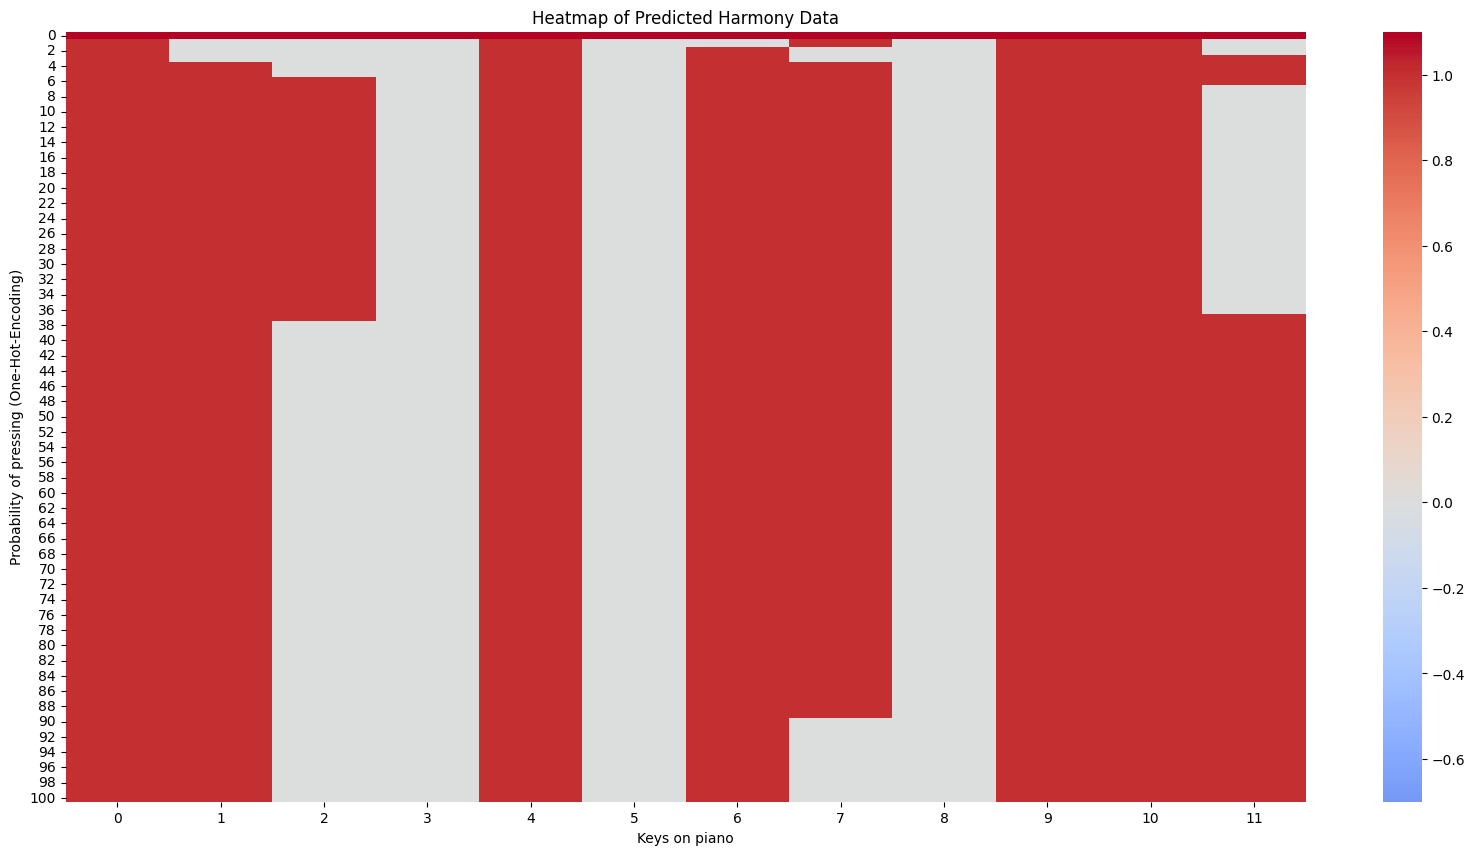

In [62]:
printHeatmap(prediction, 0, -0.7, 1.1)